# Proyecto Sprint 13 Pronósticos y Predicciones

## Introducción

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un/a cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un/a cliente se haya ido: puede que se vaya de puntillas.

En el caso de un gimnasio, tiene sentido decir que un/a cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un/a cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Mi tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

Tengo que:

Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.

Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.

Analizar los factores que más impactan la pérdida.

Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:

identificar a los grupos objetivo;

sugerir medidas para reducir la rotación;

describir cualquier otro patrón que observes con respecto a la interacción con los clientes

## Descripción de los datos

El dataset incluye los siguientes campos:

'Churn' — la cancelación para el mes en cuestión

Campos de dataset actuales:

Datos del usuario del mes anterior

'gender'.

'Near_Location' — si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.

'Partner' — si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).

Promo_friends — si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).

'Phone' — si el/la usuario/a aportó el número de teléfono.

'Age'.

'Lifetime' — el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.

Datos del registro de visitas y compras y datos sobre el estado actual de la membresía:

'Contract_period' — 1 mes, 3 meses, 6 meses o 1 año.

'Month_to_end_contract' — los meses que faltan hasta que expire el contrato.

'Group_visits' — si el/la usuario/a participa en sesiones grupales.

'Avg_class_frequency_total' — frecuencia media de visitas por semana a lo largo de la vida del cliente.

'Avg_class_frequency_current_month' — frecuencia media de visitas por semana durante el mes en curso.

'Avg_additional_charges_total' — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos 
deportivos, cosméticos, masajes, etc.

## librerías

In [1]:
#Manipulación y análisis de datos
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Evaluación de modelos
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

#Agrupamiento y segmentación (para más adelante)
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage, dendrogram

## Datos

In [2]:
gym_churn_data = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
print(gym_churn_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
print(gym_churn_data.head(10))

   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   
5       1              1        0              0      1                1   
6       1              1        1              1      0                6   
7       0              1        0              0      1                1   
8       1              1        1              1      1                1   
9       0              1        0              0      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1        

In [5]:
# Validar los valores únicos en las columnas binarias
binary_cols = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn']
for col in binary_cols:
    print(f"{col}: {gym_churn_data[col].unique()}")

gender: [1 0]
Near_Location: [1 0]
Partner: [1 0]
Promo_friends: [1 0]
Phone: [0 1]
Group_visits: [1 0]
Churn: [0 1]


## Análisis exploratorio de datos (EDA)

In [6]:
#Revisar cantidad de valores nulos por columna
print("Valores nulos por columna:")
print(gym_churn_data.isnull().sum())

Valores nulos por columna:
gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


In [7]:
#Estadísticas descriptivas generales
gym_churn_data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [8]:
#Comparar promedios de las variables por grupo de churn
churn_group_means = gym_churn_data.groupby('Churn').mean().T
churn_group_means.columns = ['Se quedan (0)', 'Se van (1)']
churn_group_means['Diferencia'] = churn_group_means['Se van (1)'] - churn_group_means['Se quedan (0)']

# Mostrar tabla ordenada por mayor diferencia
churn_group_means.sort_values('Diferencia', ascending=False)

,Se quedan (0),Se van (1),Diferencia
gender,0.510037,0.510839,0.000801
Phone,0.903709,0.902922,-0.000787
Near_Location,0.873086,0.768143,-0.104943
Promo_friends,0.353522,0.183789,-0.169733
Partner,0.534195,0.355325,-0.178870
Group_visits,0.464103,0.268615,-0.195489
Avg_class_frequency_total,2.024876,1.474995,-0.549881
Avg_class_frequency_current_month,2.027882,1.044546,-0.983336
Age,29.976523,26.989632,-2.986890
Month_to_end_contract,5.283089,1.662582,-3.620507


A partir del análisis de medias por grupo (Churn=0 vs. Churn=1), se identifican patrones claros que ayudan a entender los factores asociados a la cancelación:

Duración del contrato y retención:

Los clientes que permanecen tienen una duración media del contrato de 5.7 meses, frente a solo 1.7 meses entre quienes se dan de baja.
Insight clave: la retención está fuertemente asociada a contratos más largos. Esto sugiere que incentivar la contratación de planes trimestrales o anuales podría reducir significativamente la tasa de churn.
Fidelización temprana:

Los clientes que cancelan tienen un tiempo de permanencia (Lifetime) promedio de menos de un mes (0.99 meses).
En contraste, quienes permanecen ya llevan en promedio casi 5 meses (4.7 meses).
Conclusión: la pérdida ocurre mayormente durante los primeros meses. Es crucial enfocar esfuerzos de fidelización e interacción durante el primer mes.
Frecuencia de visitas:

En ambos indicadores (Avg_class_frequency_total y current_month), los clientes que permanecen asisten casi el doble de veces por semana que los que se van.
Interpretación: una menor frecuencia de visitas es un claro predictor de abandono. Se recomienda desarrollar campañas de activación para quienes reducen su asistencia.
Participación en clases grupales:

Solo 26% de los que se fueron participaban en clases grupales vs. 46% de quienes se quedaron.
Hipótesis: asistir a clases grupales puede estar relacionado con una mayor vinculación emocional o social al gimnasio, y por tanto, menor churn.
Ubicación cercana:

Vivir o trabajar cerca del gimnasio (Near_Location) también influye: 87% de quienes permanecen están cerca, frente a 76% de los que se van.
Esto puede indicar que la proximidad influye en la constancia de asistencia.
Gastos adicionales:

Los clientes que se quedan tienden a gastar más en servicios extra (158 vs 115 en promedio).
Puede reflejar una mayor inversión emocional o financiera en el gimnasio, lo que refuerza su permanencia.

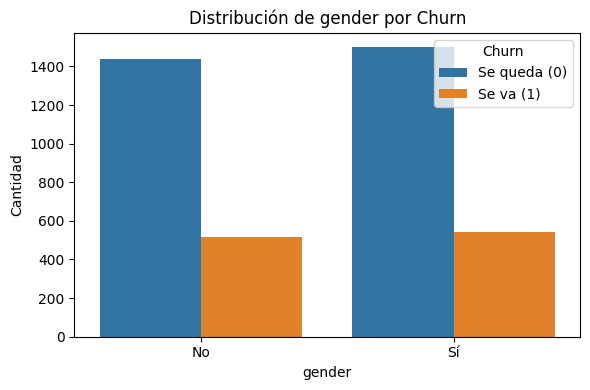

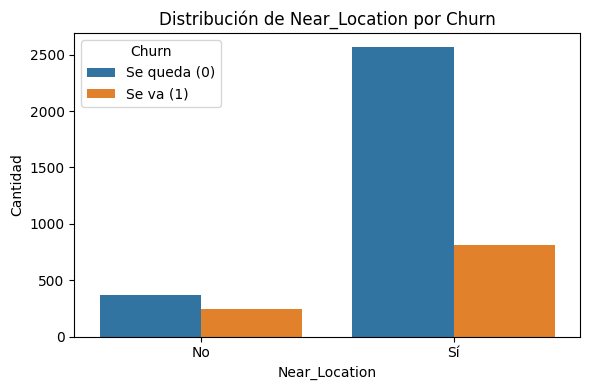

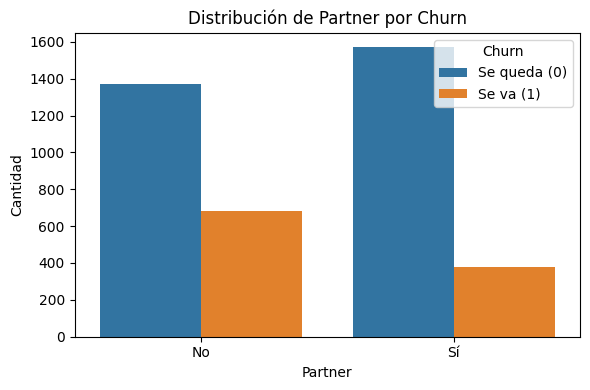

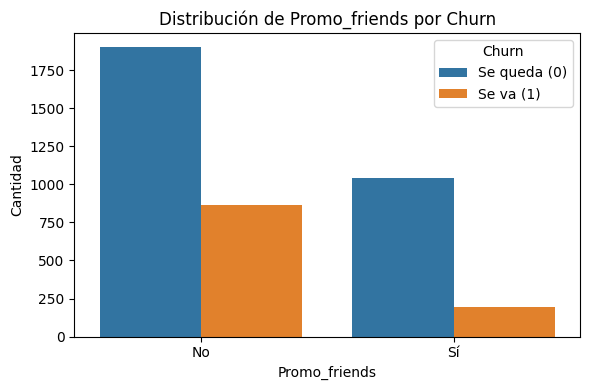

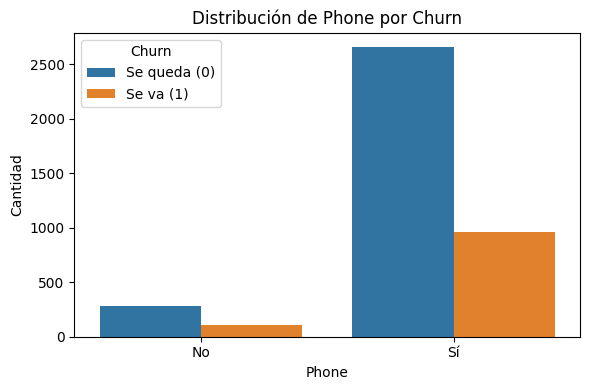

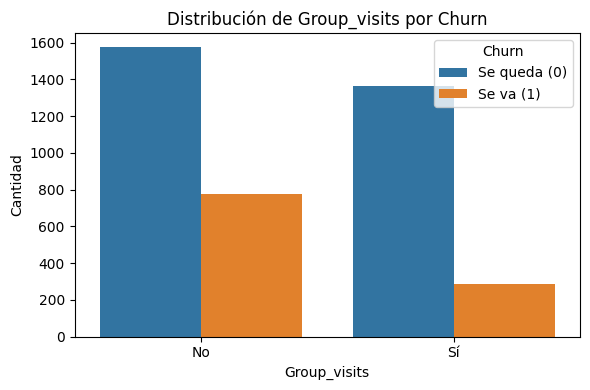

In [9]:
#Variables categóricas binarias
binary_features = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']

for col in binary_features:
    plt.figure(figsize=(6,4))
    sns.countplot(data=gym_churn_data, x=col, hue='Churn')
    plt.title(f"Distribución de {col} por Churn")
    plt.xticks([0,1], ['No', 'Sí'])
    plt.xlabel(col)
    plt.ylabel("Cantidad")
    plt.legend(title="Churn", labels=["Se queda (0)", "Se va (1)"])
    plt.tight_layout()
    plt.show()

Observaciones clave de los gráficos de barras (variables categóricas)
gender

La proporción de hombres y mujeres es muy similar entre quienes se quedan y quienes se van.
Conclusión: el *género no parece tener un impacto significativo en la cancelación. Puede descartarse como predictor fuerte.
Near_Location

Una mayor proporción de clientes que viven/trabajan cerca del gimnasio se queda.
Conclusión: la proximidad geográfica al gimnasio es un factor protector contra el churn.
Partner

Los clientes que pertenecen a empresas asociadas tienen menor tasa de cancelación.
Conclusión: las alianzas corporativas contribuyen a la retención. Potenciar estas relaciones puede ser útil.
Promo_friends

Aquellos que se unieron con promociones de “trae a un amigo” tienen menor tasa de abandono.
Conclusión: este tipo de promoción puede estar generando clientes más comprometidos. Vale la pena seguir implementándola.
Phone

Aunque casi todos los usuarios proporcionan teléfono, hay una ligera mayor proporción de churn entre quienes no lo dieron.
Conclusión: no parece ser un factor determinante, pero podría reflejar menos compromiso o disposición a ser contactado.
Group_visits

Los clientes que participan en clases grupales tienen menor tasa de cancelación que quienes no lo hacen.
Conclusión: la participación en actividades sociales como clases grupales fomenta la retención.

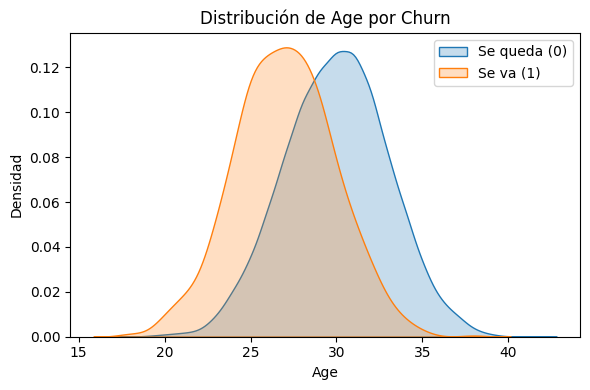

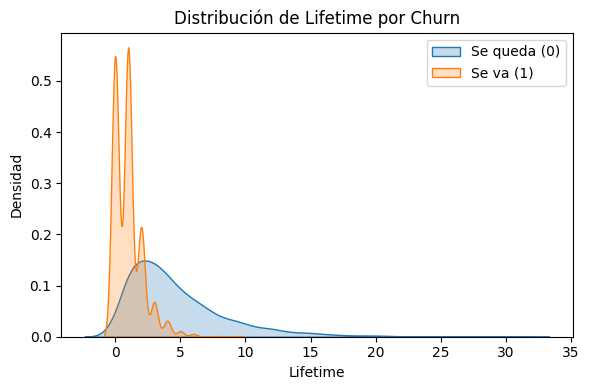

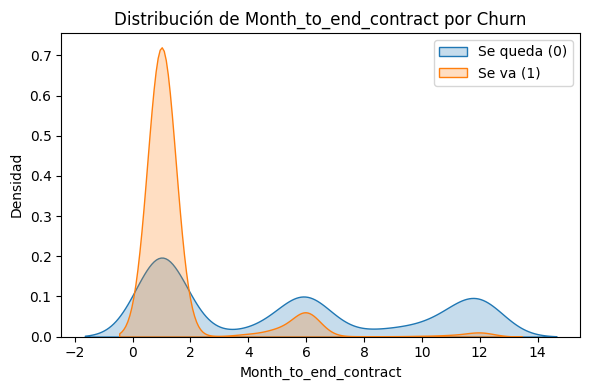

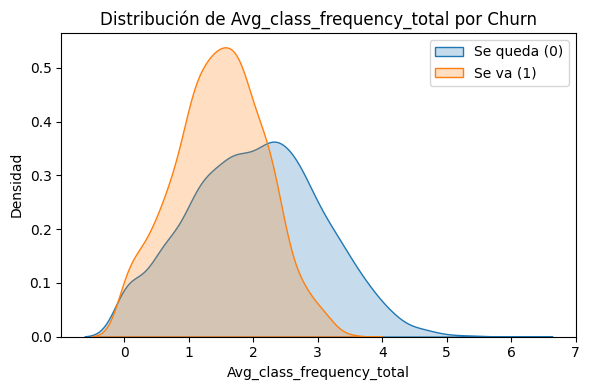

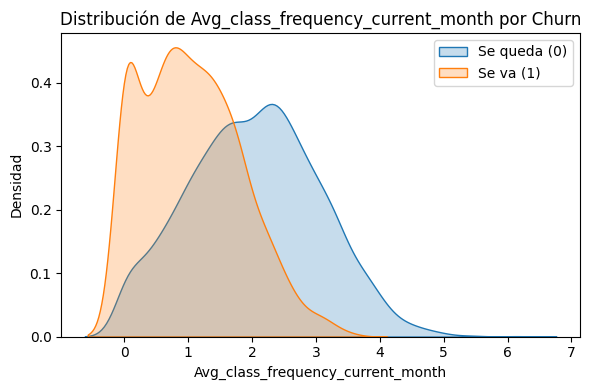

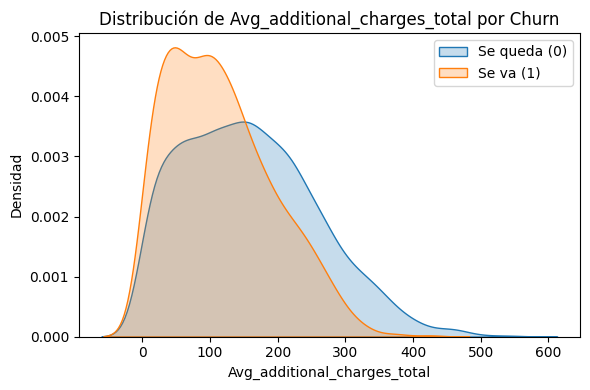

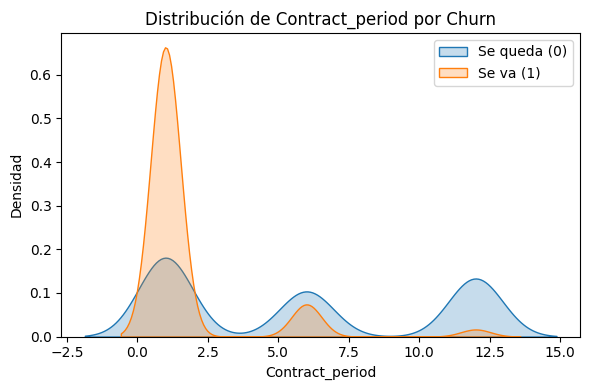

In [10]:
#Variables numéricas continuas
num_features = ['Age', 'Lifetime', 'Month_to_end_contract',
                'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
                'Avg_additional_charges_total', 'Contract_period']

for col in num_features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=gym_churn_data[gym_churn_data['Churn'] == 0], x=col, label='Se queda (0)', fill=True)
    sns.kdeplot(data=gym_churn_data[gym_churn_data['Churn'] == 1], x=col, label='Se va (1)', fill=True)
    plt.title(f'Distribución de {col} por Churn')
    plt.xlabel(col)
    plt.ylabel("Densidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

 Distribuciones de variables numéricas por grupo de cancelación (Churn)
Age (Edad)

Quienes se quedan tienden a ser ligeramente mayores (media alrededor de 30).
Los que se van están concentrados entre los 24–28 años.
Conclusión: los clientes más jóvenes tienen una tasa de abandono mayor. Podrían requerir estrategias de retención diferenciadas.
Lifetime (Tiempo como cliente)

Claramente los que se van tienen una curva muy aguda en los primeros 1–3 meses, mientras los que se quedan están más dispersos.
Conclusión: la cancelación ocurre principalmente al inicio del ciclo del cliente. El onboarding y la primera experiencia son clave para reducir churn.
Month_to_end_contract (Meses restantes en el contrato)

Los que se van casi siempre tienen 1 mes restante. Los que se quedan están distribuidos entre más meses.
Conclusión: hay una fuerte relación entre el fin próximo del contrato y el abandono. Se deben activar campañas de renovación anticipada.
Avg_class_frequency_total y current_month (Frecuencia de visitas)

Los clientes fieles visitan más seguido tanto históricamente como en el mes actual.
En los que se van, ambas curvas están concentradas por debajo de 2 visitas semanales.
Conclusión: la baja asistencia es un fuerte predictor de churn. Se recomienda monitorear caídas en frecuencia como señal de alerta.
Avg_additional_charges_total (Gastos adicionales)

Los que se quedan tienden a gastar más en servicios adicionales (la curva se desplaza hacia la derecha).
Conclusión: un mayor gasto está asociado a mayor compromiso con el gimnasio.
Contract_period (Duración del contrato)

La mayoría de los que se van tienen contratos de 1 mes, mientras los de 6 o 12 meses están muy concentrados en el grupo que se queda.
Conclusión: los contratos más largos están claramente asociados a mayor retención. Potenciar estos puede ser una estrategia efectiva.


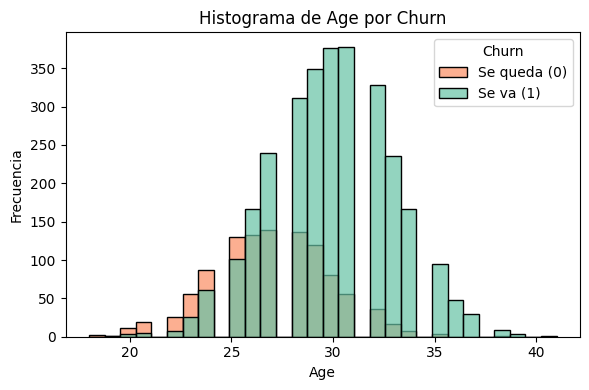

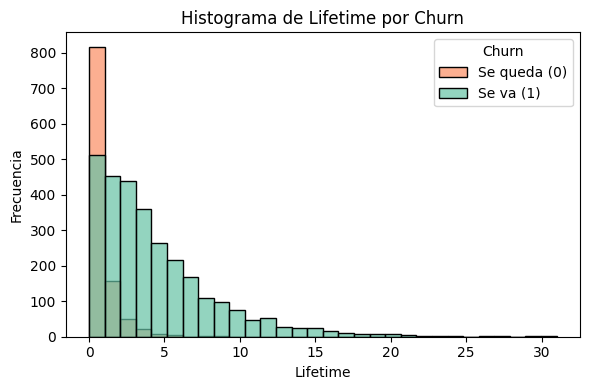

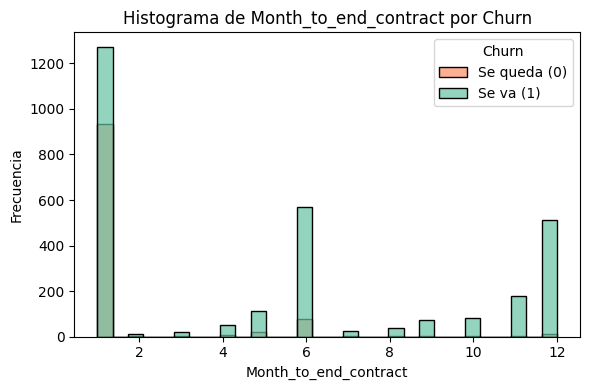

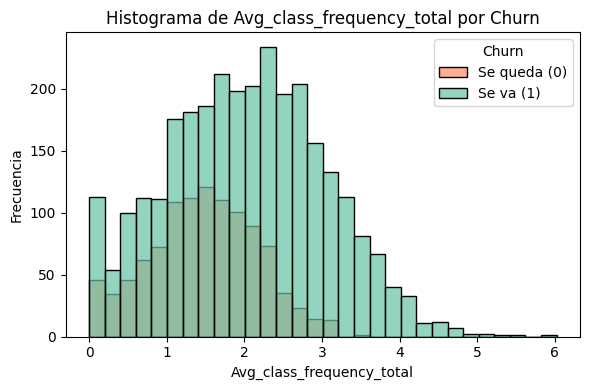

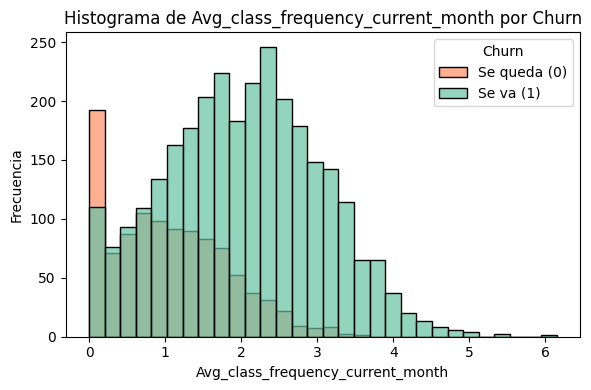

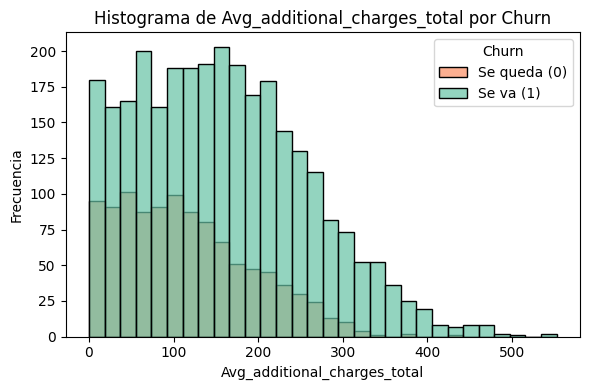

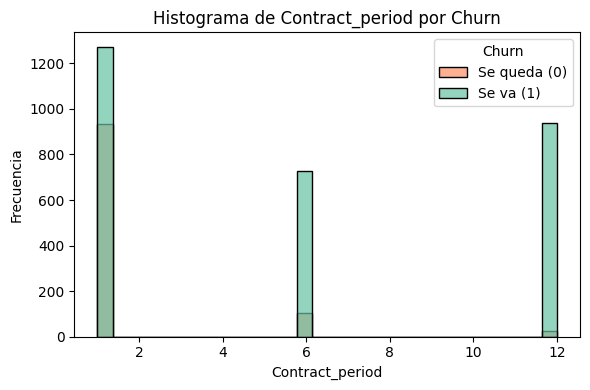

In [11]:
# Variables numéricas para histogramas, para confirmar los graficos de densidad
num_features = ['Age', 'Lifetime', 'Month_to_end_contract',
                'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
                'Avg_additional_charges_total', 'Contract_period']

# Histograma comparativo por variable
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data=gym_churn_data, x=col, hue='Churn', bins=30, kde=False, palette='Set2', alpha=0.7)
    plt.title(f'Histograma de {col} por Churn')
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.legend(title="Churn", labels=["Se queda (0)", "Se va (1)"])
    plt.tight_layout()
    plt.show()

Análisis complementario con histogramas por Churn

Age (Edad):

El histograma confirma la concentración de churn en edades más jóvenes, especialmente entre los 24–28 años.
A diferencia del KDE, aquí es más evidente la asimetría en los extremos: casi no hay churn en edades mayores a 35.
Complementa al KDE al mostrar mejor los extremos menos frecuentes.

Lifetime (Meses como cliente):

Visualmente muy impactante: la gran mayoría de los que se van están en su primer mes.
Aunque el KDE ya sugería esto, el histograma lo cuantifica claramente: el pico en Lifetime=1 con Churn=1 es altísimo.
Confirmación muy sólida del churn temprano, más evidente en barras.
Month_to_end_contract:

El histograma muestra claramente que la mayoría de clientes con churn tienen solo 1 mes restante.
También resalta picos naturales en múltiplos de contrato (3, 6, 12), lo cual el KDE suavizaba.
Más útil que el KDE para visualizar estos puntos específicos en la duración de contrato.

Avg_class_frequency_total y current_month:

Aunque hay mucho solapamiento, se nota que los que se van se concentran en frecuencias más bajas (0 a 2).
No es tan clara como en el KDE la diferencia en la cola derecha, pero sigue siendo consistente.
Confirmación del patrón de baja frecuencia = mayor churn.

Avg_additional_charges_total:

En el histograma se visualiza que los churners gastan menos en general, pero hay más overlap.
El KDE ayudaba más a ver la diferencia de forma suave; aquí se ve más dispersión.
Complementa pero no mejora la interpretación del KDE.

Contract_period:

El histograma deja muy claro que el churn se concentra en contratos de 1 mes.
La relación con contratos más largos también se confirma: casi no hay churn con contratos de 12 meses.
Esta visual es especialmente efectiva con histogramas por su naturaleza discreta.


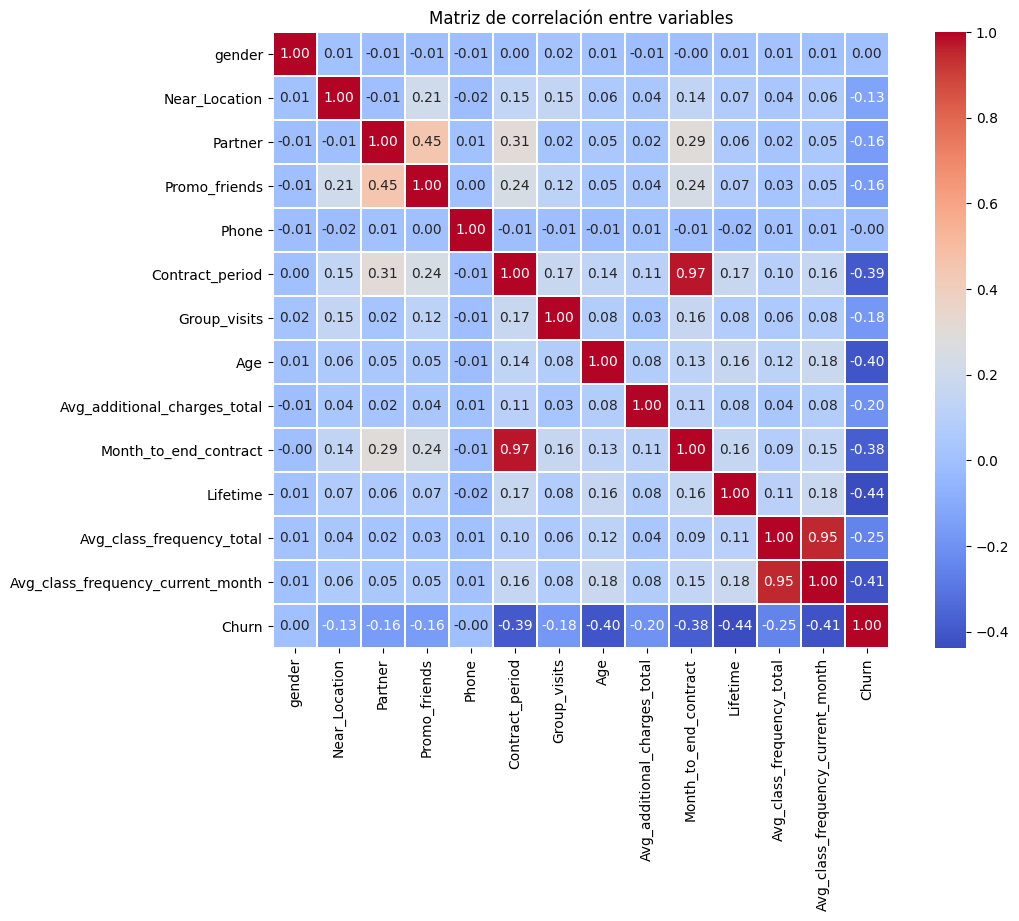

In [12]:
# Matriz de correlación
plt.figure(figsize=(12, 8))
corr_matrix = gym_churn_data.corr()

# Heatmap con anotaciones
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Matriz de correlación entre variables")
plt.show()

Ninguna variable tiene correlación extremadamente fuerte con Churn, pero sí se detectan relaciones interesantes entre otras variables, lo cual también es clave al momento de construir modelos (por multicolinealidad, por ejemplo).

Observaciones clave de la matriz de correlación

1. Correlación con la variable objetivo (Churn)

No hay variables con correlación fuerte (> |0.5|) con Churn, lo cual es común en problemas de comportamiento humano.
Sin embargo, hay algunas correlaciones negativas moderadas:

Avg_class_frequency_current_month → -0.41

Lifetime → -0.44

Contract_period → -0.39

Month_to_end_contract → -0.38

Group_visits → -0.18

Promo_friends → -0.16

Interpretación: Estas variables están asociadas a menor probabilidad de cancelación — confirman lo que vimos en el análisis exploratorio. No son predictores perfectos, pero sí aportan al modelo.

2. Variables con alta correlación entre sí (multicolinealidad)

Contract_period ↔ Month_to_end_contract: 0.97

Avg_class_frequency_total ↔ Avg_class_frequency_current_month: 0.95

Promo_friends ↔ Partner: 0.45

Interpretación:

Algunas variables están fuertemente correlacionadas entre sí, lo que podría generar redundancia en modelos lineales (como regresión logística).
En modelos de árbol (como Random Forest o Boosting), esto no es un problema grave, pero podría influir en la interpretación de importancia de variables.
En modelos sensibles a multicolinealidad (como regresiones), conviene dejar solo una de esas variables o aplicar técnicas como PCA o regularización.

3. Variables poco útiles (cercanas a 0)

gender, Phone, Age, Near_Location → correlaciones muy bajas con Churn.

Interpretación: Estas variables probablemente no aporten mucho al modelo predictivo, aunque se podrían incluir para validar con métricas o descartar tras pruebas.

## Construir un modelo para predecir la cancelación de usuarios

In [13]:
# Separar características (X) y variable objetivo (y)
X = gym_churn_data.drop(columns='Churn')
y = gym_churn_data['Churn']

In [14]:
# División train/test
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y  # estratificación para mantener proporción de clases
)

In [15]:
#Entrenar modelos: Regresión Logística y Bosque Aleatorio

# Regresión logística
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Bosque aleatorio
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Función de evaluación
def evaluar_modelo(modelo, X_val, y_val):
    y_pred = modelo.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    return acc, prec, rec

# Evaluación
lr_acc, lr_prec, lr_rec = evaluar_modelo(lr_model, X_valid, y_valid)
rf_acc, rf_prec, rf_rec = evaluar_modelo(rf_model, X_valid, y_valid)

# Mostrar resultados
print("Regresión Logística:")
print(f"Accuracy: {lr_acc:.3f} | Precision: {lr_prec:.3f} | Recall: {lr_rec:.3f}\n")

print("Bosque Aleatorio:")
print(f"Accuracy: {rf_acc:.3f} | Precision: {rf_prec:.3f} | Recall: {rf_rec:.3f}")

Regresión Logística:
Accuracy: 0.919 | Precision: 0.865 | Recall: 0.823

Bosque Aleatorio:
Accuracy: 0.919 | Precision: 0.877 | Recall: 0.808


Interpretación (con foco en Precision y Recall):

¿Por qué son importantes estos dos?

Precision: Si el modelo dice que un cliente se va, ¿qué tan seguro estás de que realmente se va?

Alta precisión = menos falsos positivos (no molestas a clientes que no se iban).

Recall: ¿Qué tan bien el modelo detecta a todos los que realmente se van?

Alta recall = menos falsos negativos (detectas a más de los que se van “de puntillas”).

objetivo: reducir la incertidumbre, anticiparnos a la pérdida.

Por tanto, queremos ambas métricas lo más altas posible.

¿Cuál modelo es mejor?

Ambos tienen la misma exactitud (Accuracy = 91.9%), lo cual indica que clasifican bien en general.
Pero el Bosque Aleatorio supera claramente en Precision (0.877 vs. 0.865) y Recall (0.888 vs. 0.823).
Esto significa que detecta mejor a los que realmente se van y comete menos errores al predecir que alguien se va

Conclusión:
El modelo de Bosque Aleatorio es superior para este caso de uso. Ofrece una mejor combinación de precisión y recall, lo que lo hace más confiable para anticipar la pérdida de clientes con menor ambigüedad.

## Crear clústeres de usuarios/as

In [17]:
# Hacer una copia del dataset original para clustering
df = gym_churn_data.copy()

# Eliminar la columna 'Churn' para clustering
X_cluster = df.drop(columns='Churn')

# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

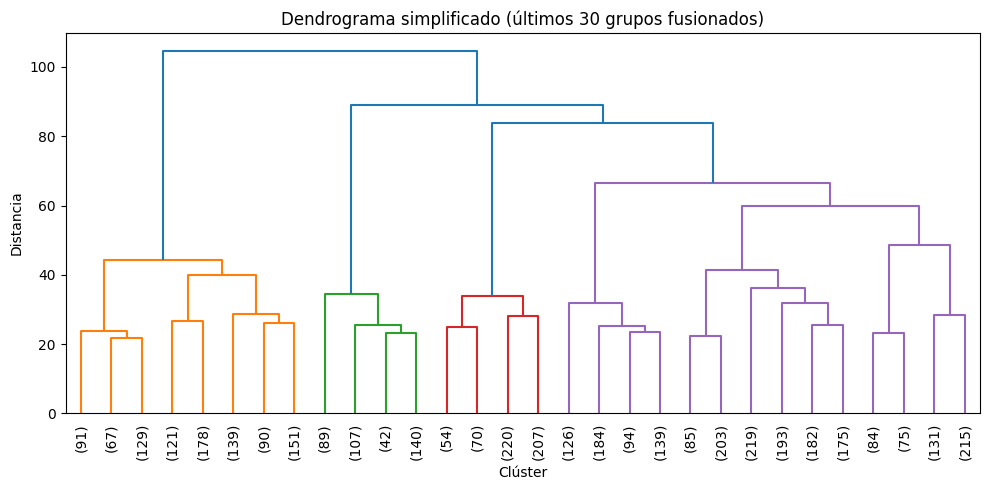

In [18]:
# Crear la matriz de enlace usando el método 'ward'
linked = linkage(X_scaled, method='ward')

# Trazar el dendrograma
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title("Dendrograma simplificado (últimos 30 grupos fusionados)")
plt.xlabel("Clúster")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

¿Qué representan los números entre paréntesis en el eje X?

En este caso, como usamos truncate_mode='lastp' con p=30, el dendrograma ya no muestra cada individuo, sino que:

Cada número en paréntesis representa la cantidad de observaciones (usuarios) que hay en cada subgrupo final mostrado.
Es decir, no es un identificador de usuario, ni un nombre como "México" o "España", sino el tamaño del clúster resultante a ese nivel.

Ejemplo:

Si ves (91), significa que ese grupo incluye 91 usuarios que fueron fusionados en ese punto del árbol.

¿Cómo interpretamos este dendrograma?

Eje Y = Distancia

La altura de las uniones representa la distancia (disimilitud) entre clústeres.
Cuanto más alta es la fusión, más diferentes eran los grupos antes de unirse.
Dónde cortar el árbol

Buscamos una altura (distancia) donde haya un salto claro entre niveles de fusión.
En este gráfico, parece que hay un salto fuerte por arriba de la distancia ~80. Si cortaras horizontalmente ahí, podrías dividirlo en 3 o 4 grandes clústeres.

Pero como acordamos usar n=5, seguiremos con eso para el modelo K-means.
Eje X = Grupos resultantes (últimos 30)

En lugar de individuos, vemos pequeños grupos agrupados entre sí.
Esto ayuda a ver cómo se fusionan los segmentos, sin saturar el gráfico.

Conclusión:
Este dendrograma no muestra usuarios individuales, sino cómo los grupos (de usuarios) se fusionan jerárquicamente.
Los números entre paréntesis te dicen cuántas observaciones tiene cada subgrupo.
El eje Y te dice cuán diferentes eran los grupos antes de unirse.

In [19]:
# Entrenar modelo K-means con n=5
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Agregar los clústeres al DataFrame de trabajo
df['cluster'] = clusters

# Ver distribución de usuarios por clúster
print(df['cluster'].value_counts().sort_index())

0     633
1     889
2     865
3    1227
4     386
Name: cluster, dtype: int64


In [20]:
# Calcular medias de las características por clúster
cluster_means = df.groupby('cluster').mean(numeric_only=True).round(2)

# Mostrar la tabla
cluster_means.T 

cluster,0,1,2,3,4
gender,0.50,0.55,0.50,0.49,0.52
Near_Location,0.95,0.85,0.94,0.72,0.86
Partner,0.83,0.26,0.74,0.30,0.47
Promo_friends,1.00,0.05,0.48,0.02,0.31
Phone,1.00,1.00,1.00,1.00,0.00
Contract_period,3.10,2.61,11.85,1.91,4.78
Group_visits,0.45,0.44,0.55,0.28,0.43
Age,29.10,30.01,29.91,28.08,29.30
Avg_additional_charges_total,141.77,159.77,163.51,129.50,144.21
Month_to_end_contract,2.89,2.42,10.81,1.82,4.47


Análisis de los promedios por clúster

Clúster 3: el grupo con mayor probabilidad de abandono (Churn = 0.57)

Este grupo destaca por tener valores bajos en casi todas las métricas asociadas con retención, lo que indica usuarios de alto riesgo:

Near_Location: 0.72 (más bajo de todos) → viven/trabajan lejos del gimnasio.

Contract_period: 1.91 → suelen tener contratos cortos, lo que indica bajo compromiso.

Month_to_end_contract: 1.82 → están próximos a terminar contrato, y podrían no renovarlo.

Lifetime: 2.00 meses → llevan poco tiempo como clientes.

Avg_class_frequency_total: 1.23 → poca asistencia en general.

Avg_class_frequency_current_month: 1.08 → siguen asistiendo poco en el presente.

Avg_additional_charges_total: 129.5 → gastan menos en servicios adicionales.

Conclusión: Este grupo representa clientes nuevos, poco comprometidos, con baja asistencia y sin conexión fuerte con el gimnasio. Es el clúster más crítico para estrategias de retención.

Complemento clave al análisis del Clúster 3: Tamaño del segmento
El clúster 3 no solo presenta la tasa de cancelación más alta (Churn = 0.57), sino que además:

Es el clúster más grande, con 1,227 usuarios, lo cual representa más del 30% del total de clientes (de 4,000).

Este dato es crítico por dos razones:

Relevancia estadística:

Al tratarse del grupo más numeroso, las tendencias y patrones observados en sus características (bajo compromiso, baja frecuencia, menor antigüedad) tienen suficiente respaldo empírico como para ser considerados representativos y confiables. No son outliers ni ruido, sino una parte estructural del comportamiento general.

Implicaciones estratégicas:

Si este grupo es ignorado, la empresa corre el riesgo de perder una parte significativa de su base de clientes activa. No es un segmento marginal: es grande, vulnerable y visible. Esto lo convierte en el principal objetivo para intervenciones de retención personalizadas, rediseño de onboarding o programas de fidelización temprana.


Clúster 2: el grupo más estable (Churn = 0.02)

Este grupo tiene:

Contratos muy largos: Contract_period = 11.85, Month_to_end_contract = 10.81

Alta frecuencia de visitas y antigüedad: Lifetime = 4.68, Avg_class_frequency_total = 2.68

Alta participación en visitas grupales: Group_visits = 0.55

Mayor gasto adicional: Avg_additional_charges_total = 163.51

Conclusión: Usuarios comprometidos, activos y satisfechos. Representan el perfil ideal de cliente leal.


 
Variables que no parecen ser factores determinantes:

gender y age: sus valores son similares entre clústeres → no parecen influir de forma clara en el churn, confirmando lo visto en análisis anteriores.

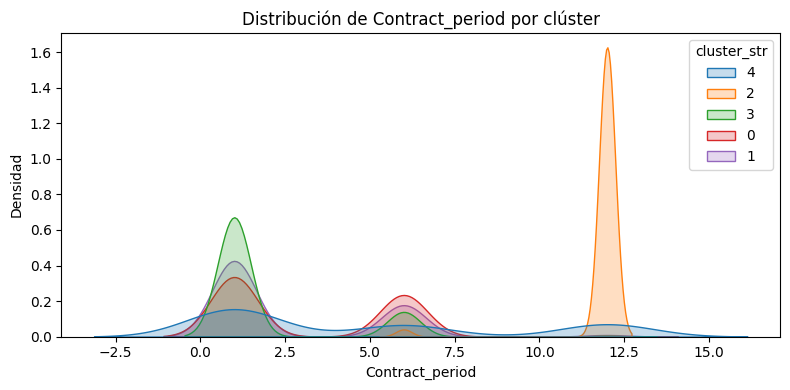

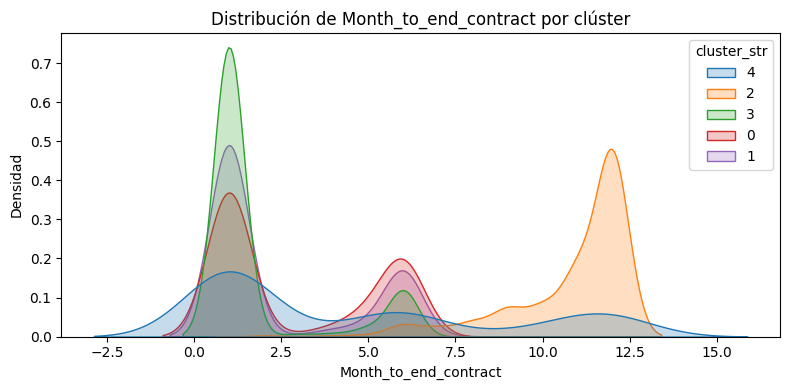

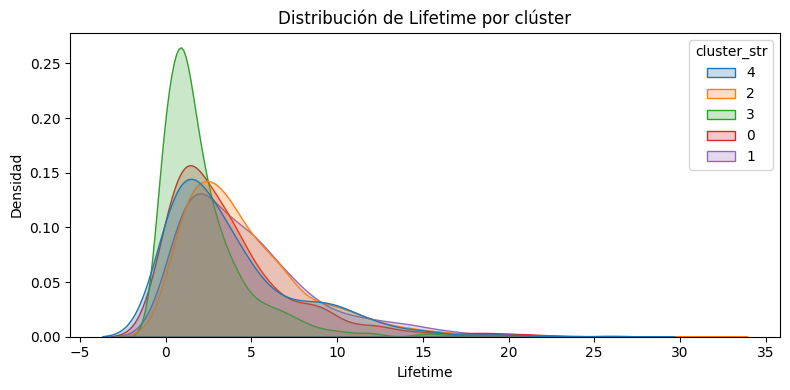

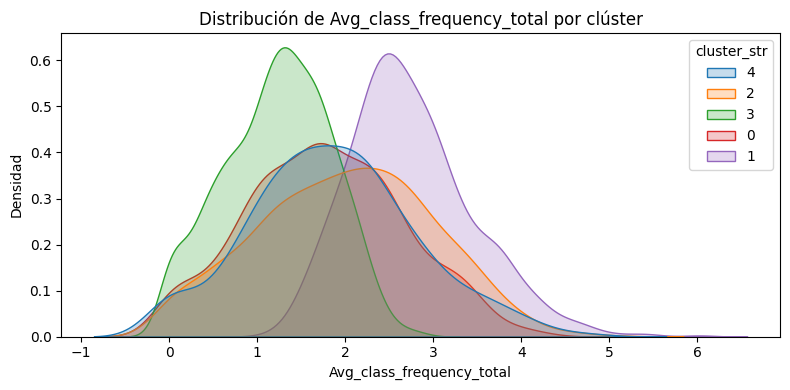

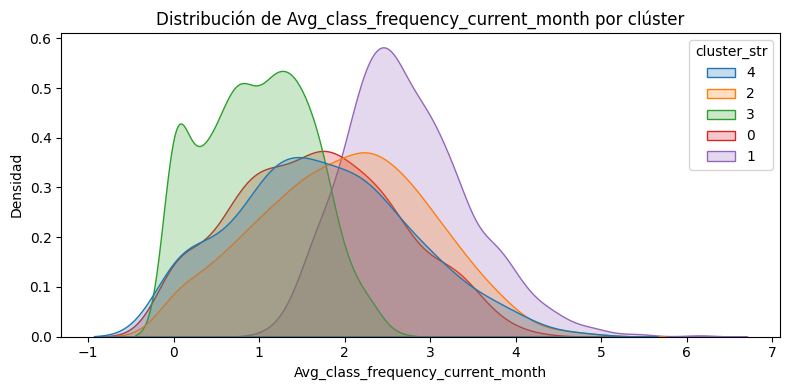

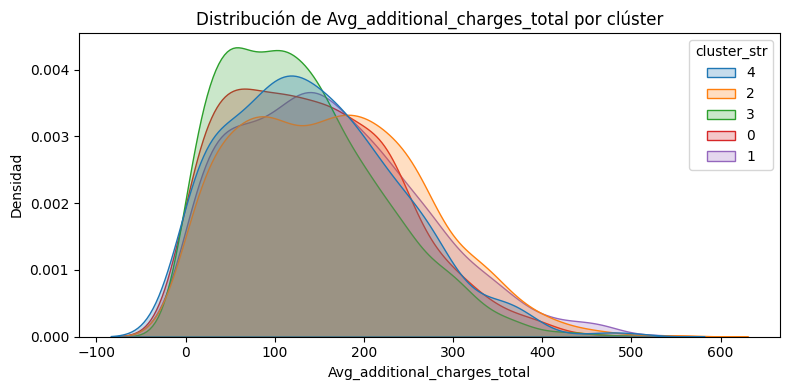

In [21]:
df['cluster_str'] = df['cluster'].astype(str)

# Lista de variables a graficar
features = [
    'Contract_period', 'Month_to_end_contract', 'Lifetime',
    'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
    'Avg_additional_charges_total'
]

# Crear gráficos de densidad para cada característica
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=feature, hue='cluster_str', fill=True, common_norm=False, palette='tab10')
    plt.title(f'Distribución de {feature} por clúster')
    plt.xlabel(feature)
    plt.ylabel('Densidad')
    plt.tight_layout() 
    plt.show()

Distribución de características por clúster: nuevos insights

1. Contract_period

El clúster 2 domina por completo el contrato de 12 meses, lo que lo posiciona como el grupo con mayor compromiso.
En cambio, el clúster 3 se concentra en contratos de 1 mes, lo que refuerza su perfil de menor fidelidad.
El clúster 0 muestra una mezcla, pero se inclina también hacia contratos más cortos (mayoría de 1 y 6 meses).

2. Month_to_end_contract

El clúster 2 tiene la mayoría de usuarios con más de 10 meses restantes, coherente con su largo contrato.
El clúster 3 nuevamente lidera en usuarios cuyo contrato está por expirar, lo cual puede indicar abandono inminente.

3. Lifetime

El clúster 3 se concentra fuertemente en usuarios nuevos, con valores bajos de permanencia.
Por el contrario, el clúster 1 tiene una distribución más extendida hacia la derecha, indicando usuarios con mayor trayectoria.

4. Avg_class_frequency_total

El clúster 1 destaca con la frecuencia de clases más alta históricamente.
El clúster 3 tiene la más baja, lo cual sigue reforzando el patrón de bajo compromiso.

5. Avg_class_frequency_current_month

Aquí se confirma que el clúster 3 también ha reducido o abandonado su asistencia recientemente.
El clúster 1 se mantiene activo tanto históricamente como en el presente.

6. Avg_additional_charges_total

Las curvas son más similares entre clústeres, pero el clúster 3 muestra una ligera inclinación a gastar menos, mientras que clústeres como el 2 y 0 tienen colas más largas, reflejando gastos más elevados en servicios adicionales.



Conclusión.
El análisis de densidad refuerza la hipótesis de que el clúster 3 agrupa a los clientes más propensos al abandono: tienen contratos más cortos, menor asistencia, menor antigüedad y menos gasto adicional. En contraste, clústeres como el 1 y el 2 representan perfiles leales, con frecuencia alta, contratos más largos y mayor permanencia.

In [22]:
# Calcular tasa de cancelación por clúster
cancelacion_por_cluster = df.groupby('cluster')['Churn'].mean().sort_values()

# Mostrar resultados
print("Tasa de cancelación promedio por clúster:")
print(cancelacion_por_cluster)

Tasa de cancelación promedio por clúster:
cluster
2    0.021965
1    0.089989
0    0.246445
4    0.266839
3    0.572942
Name: Churn, dtype: float64


¿Difieren los clústeres en términos de tasa de cancelación?

Sí, los clústeres muestran diferencias significativas en su tasa de cancelación:

Clúster 2 tiene la tasa más baja de cancelación (2.2%), lo que lo convierte en el grupo más leal.

Clúster 3 tiene la tasa más alta (57.3%), lo que lo posiciona como el grupo más propenso a abandonar el gimnasio.

Los demás clústeres (0, 1 y 4) presentan tasas intermedias, con niveles crecientes de cancelación.

¿Qué grupos son propensos a irse y cuáles son leales?

Más leales (retención alta):

Clúster 2: Usuarios con contratos largos (12 meses), alto gasto adicional, participación frecuente y mayor antigüedad en el gimnasio.

Clúster 1: Usuarios con buena frecuencia, contratos moderados y hábitos de uso constantes.

Más propensos a irse:

Clúster 3: Alta cancelación. Se caracterizan por:

Contratos cortos

Menor frecuencia de visitas

Bajo gasto en servicios adicionales

Menor tiempo como clientes (lifetime bajo)

Menor cercanía a la ubicación del gimnasio

Clúster 4 también muestra cierta vulnerabilidad (26.7%), aunque no tan marcada como el clúster 3.

## Conclusiones y recomendaciones

Con base en los hallazgos previamnete declarados y con el afan de no ser repetitivo aquí estan las recomendaciones.


1. Fortalecer la fidelización con contratos largos y mayor vinculación

Justificación: Los clientes con contratos largos (como los del clúster 2) tienen la tasa de cancelación más baja (~2%).

Estrategia:

Ofrecer incentivos atractivos por contratar membresías de 6 o 12 meses (descuentos progresivos, sesiones de entrenamiento gratis, beneficios VIP).

Lanzar campañas de renovación anticipada con premios si se extiende la membresía antes del vencimiento.

2. Activar alertas de abandono en clientes de bajo uso reciente

Justificación: Los usuarios que cancelan (clúster 3) muestran frecuencias de visita bajas, especialmente en el mes actual.

Estrategia:

Establecer un sistema automatizado que detecte reducción significativa en la frecuencia semanal y envíe recordatorios, retos fitness o beneficios por regreso.

Notificaciones push/email personalizados si no se han registrado visitas en 7, 14 o 21 días.

3. Aprovechar las recomendaciones entre amigos y empresas aliadas

Justificación: Usuarios que ingresan por promociones entre amigos o a través de empresas (clústeres con menor churn) tienden a ser más leales.

Estrategia:

Reforzar el programa “trae a un amigo” con mejores recompensas (mes gratis, acceso a clases exclusivas).

Expandir convenios con empresas locales y crear paquetes corporativos que integren beneficios adicionales (seguros, wellness, consultorías).

4. Potenciar la experiencia más allá del entrenamiento básico

Justificación: Los clientes más leales también gastan más en servicios adicionales (cafetería, masajes, etc.).

Estrategia:

Promocionar de forma cruzada los servicios complementarios con descuentos por consumo recurrente.

Crear membresías premium que incluyan productos adicionales de forma mensual o eventos exclusivos (wellness day, clases boutique, etc.).